In [1]:
import os
import json
import numpy as np
import pandas as pd

from PIL import Image

import torch
import torch.nn.functional as F
import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
# from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

/environment/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device cuda:0


In [4]:
model = torch.load('checkpoint/best-0.936.pth')
model = model.eval().to(device)

In [5]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()
idx_to_labels

{0: 'alligator apple',
 1: 'apple',
 2: 'avocado',
 3: 'banana',
 4: 'barberry',
 5: 'bayberry',
 6: 'bell pepper',
 7: 'black berry',
 8: 'black cherry',
 9: 'blueberry',
 10: 'bottle gourd',
 11: 'cantaloupe',
 12: 'carambola',
 13: 'cherry',
 14: 'coconut',
 15: 'corn kernel',
 16: 'custard apple',
 17: 'dragonfruit',
 18: 'durian',
 19: 'eggplant',
 20: 'fig',
 21: 'grape',
 22: 'jackfruit',
 23: 'jalapeno',
 24: 'kiwi',
 25: 'lemon',
 26: 'lime',
 27: 'longan',
 28: 'macadamia',
 29: 'mango',
 30: 'orange',
 31: 'papaya',
 32: 'pea',
 33: 'peanut',
 34: 'pear',
 35: 'persimmon',
 36: 'pineapple',
 37: 'pomegranate',
 38: 'pumpkin',
 39: 'saguaro',
 40: 'strawberry',
 41: 'tomato',
 42: 'watermelon',
 43: 'zucchini'}

In [6]:
from torchvision import transforms

transform_A = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),          
    transforms.ToTensor()         
])

transform_B = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

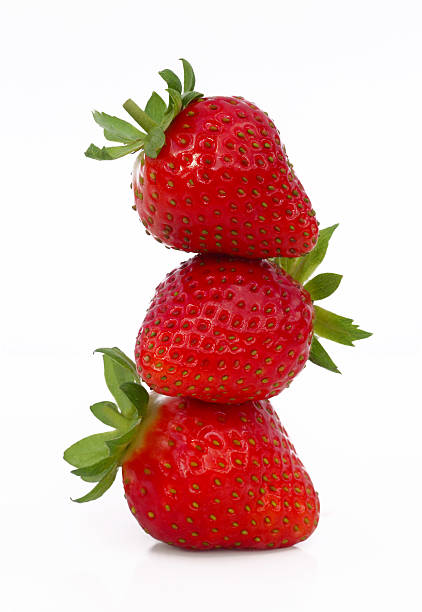

In [7]:
img_path = 'Fruit-Project_split/test/strawberry/291.jpg'
img_pil = Image.open(img_path)
img_pil

In [8]:
rc_img = transform_A(img_pil)
rc_img_norm = np.transpose(rc_img.squeeze().cpu().detach().numpy(), (1,2,0))
input_tensor = transform_B(rc_img).unsqueeze(0).to(device)

In [9]:
pred_logits = model(input_tensor)
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

pred_conf, pred_id = torch.topk(pred_softmax, 1)
pred_conf = pred_conf.detach().cpu().numpy().squeeze().item()
pred_id = pred_id.detach().cpu().numpy().squeeze().item()
pred_label = idx_to_labels[pred_id]

print('ID of the prediction category {} name {} confidence {:.2f}'.format(pred_id, pred_label, pred_conf))

ID of the prediction category 40 name strawberry confidence 1.00


In [10]:
integrated_gradients = IntegratedGradients(model)

In [11]:
attributions_ig = integrated_gradients.attribute(input_tensor, target=pred_id, n_steps=200)

attributions_ig_norm = np.transpose(attributions_ig.detach().cpu().squeeze().numpy(), (1,2,0))

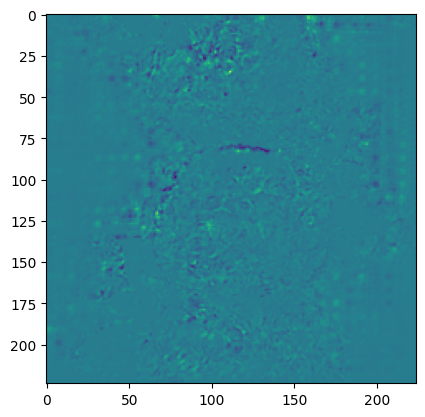

In [12]:
plt.imshow(attributions_ig_norm[:, :, 0] * 100)
# plt.imshow(attributions_ig_norm[:, :, 1] * 100)
# plt.imshow(attributions_ig_norm[:, :, 2] * 100)
plt.show()

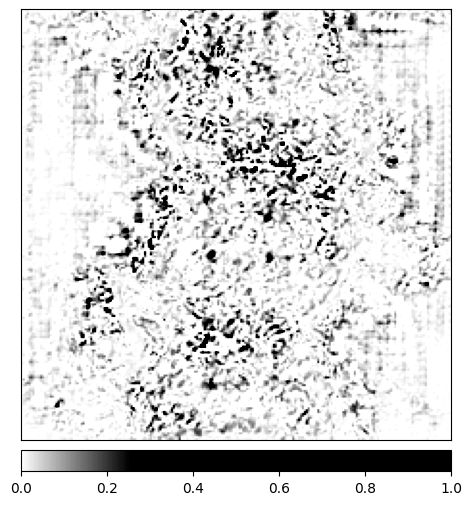

In [13]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

viz.visualize_image_attr(attributions_ig_norm, # 224,224,3
                         rc_img_norm,          # 224,224,3
                         method='heat_map',
                         cmap=default_cmap,
                         show_colorbar=True,
                         sign='positive',
                         outlier_perc=1)
plt.show()

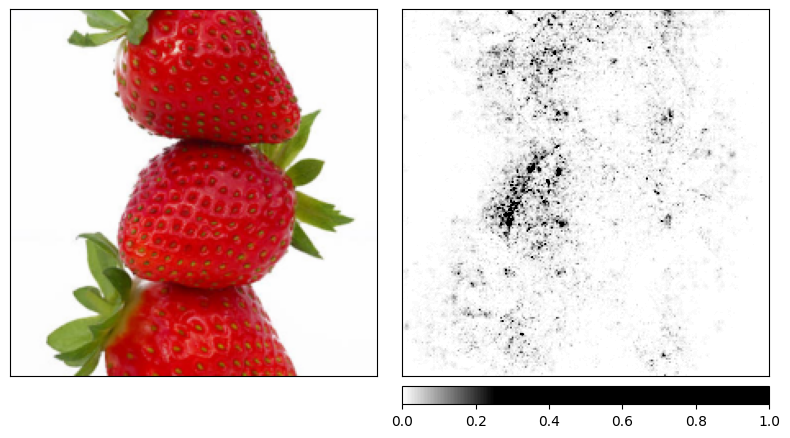

In [9]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input_tensor, nt_samples=3, nt_type='smoothgrad_sq', target=pred_id)


attributions_ig_nt_norm = np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0))


default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

viz.visualize_image_attr_multiple(attributions_ig_nt_norm, # 224 224 3
                                  rc_img_norm, # 224 224 3
                                  ["original_image", "heat_map"],
                                  ["all", "positive"],
                                  cmap=default_cmap,
                                  show_colorbar=True)
plt.show()